In [15]:
# imports and setup
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from PIL import Image
import random
from collections import Counter

# define path
data_dir = Path("..") / "data" 

#set seed
np.random.seed(88)

# Brain Tumor Detection - Exploratory Data Analysis

## 1. Introduction

**Objective:** Build a deep learning classifier to detect and classify brain tumors from MRI images.

**Dataset:** [**"Br35H :: Brain Tumor Detection 2020"**]
- Source: [[Link](https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection)]
- Total samples: 1500 images
- Classes: [tumor, healthy]

### 2. Class Distributions
Before training, we’ll examine the sample counts across all datasets and visualize the overall distribution.


{'healthy': 1500, 'tumor': 1500}


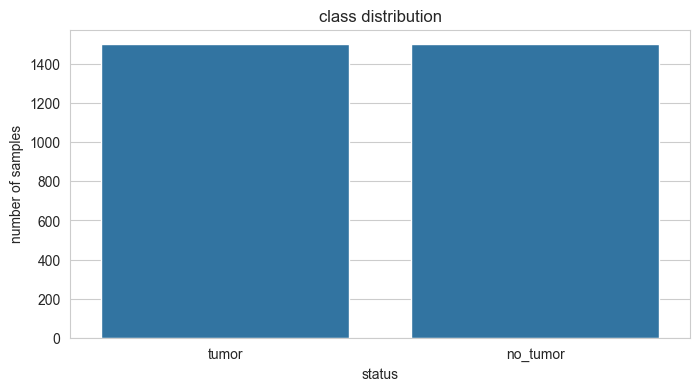

In [16]:
# count samples
def count_samples(directory):
    return {
        cls: len(os.listdir(os.path.join(directory, cls))) 
        for cls in os.listdir(directory) 
        if os.path.isdir(os.path.join(directory, cls))
    }

# get counts
counts = count_samples(data_dir)
print(counts)

# name cols
counts['tumor'] = counts.pop('tumor')
counts['no_tumor'] = counts.pop('healthy')

# convert to dataframe
df = pd.DataFrame(list(counts.items()), columns=["label", "count"])

# plot
sns.set_style("whitegrid")
plt.figure(figsize=(8, 4))
sns.barplot(x="label", y="count", data=df)
plt.title("class distribution")
plt.ylabel("number of samples")
plt.xlabel("status")

# ensure folder exists
os.makedirs("../graphics", exist_ok=True)
plt.savefig("../graphics/class_distribution.png", bbox_inches="tight")
plt.show()

From what we can see above:
- classes contain the following sample counts:  
  - healthy: 1500
  - tumor: 1500
- The classes are perfectly balanced.
- No oversampling or class weighting is required.



### 3. Image Quality

To ensure our model learns meaningul patterns from the input images, we need to make sure the images are of good quality. 

In [17]:
# Image Quality Checks

def check_image_quality(data_dir, sample_size=100):
    """check for corrupted files, dimensions, and quality issues"""
    
    quality_report = {
        'total_checked': 0,
        'corrupted': [],
        'too_small': [],
        'dimensions': [],
        'file_sizes': [],
        'modes': []
    }
    
    classes = [cls for cls in os.listdir(data_dir) 
               if os.path.isdir(os.path.join(data_dir, cls))]
    
    for cls in classes:
        class_path = os.path.join(data_dir, cls)
        images = [f for f in os.listdir(class_path) 
                 if f.endswith(('.jpg', '.png', '.jpeg'))]
        
        sample = random.sample(images, min(sample_size, len(images)))
        
        for img_name in sample:
            img_path = os.path.join(class_path, img_name)
            quality_report['total_checked'] += 1
            
            try:
                img = Image.open(img_path)
                
                # get properties
                width, height = img.size
                quality_report['dimensions'].append((width, height))
                quality_report['modes'].append(img.mode)
                quality_report['file_sizes'].append(os.path.getsize(img_path) / 1024)  # KB
                
                # check if too small
                if width < 100 or height < 100:
                    quality_report['too_small'].append(img_path)
                
                img.verify()
                
            except Exception as e:
                quality_report['corrupted'].append((img_path, str(e)))
    
    return quality_report

print("checking image quality (sampling 200 images per class)...")
quality = check_image_quality(data_dir, sample_size=200)

print(f"\n")
print("IMAGE QUALITY REPORT")
print(f"total images checked: {quality['total_checked']}")
print(f"corrupted files: {len(quality['corrupted'])}")
print(f"too small (<100px): {len(quality['too_small'])}")

if quality['corrupted']:
    print("\ncorrupted files found:")
    for path, error in quality['corrupted'][:5]:
        print(f"  - {path}: {error}")

if quality['too_small']:
    print("\ntoo small files found:")
    for path in quality['too_small'][:5]:
        print(f"  - {path}")

checking image quality (sampling 200 images per class)...


IMAGE QUALITY REPORT
total images checked: 400
corrupted files: 0
too small (<100px): 0




FILE SIZE ANALYSIS
Mean size: 23.0 KB
Median size: 14.9 KB
Min size: 5.0 KB
Max size: 195.5 KB


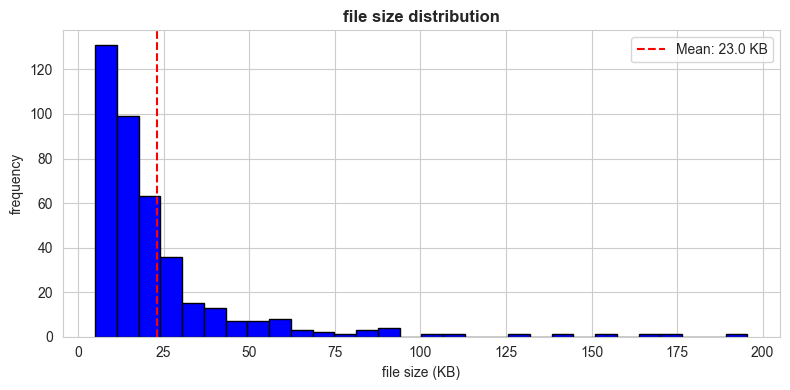

In [18]:
# file Size Analysis
file_sizes = quality['file_sizes']

print(f"\n")
print("FILE SIZE ANALYSIS")
print(f"Mean size: {np.mean(file_sizes):.1f} KB")
print(f"Median size: {np.median(file_sizes):.1f} KB")
print(f"Min size: {min(file_sizes):.1f} KB")
print(f"Max size: {max(file_sizes):.1f} KB")

plt.figure(figsize=(8, 4))
plt.hist(file_sizes, bins=30, color='blue', edgecolor='black')
plt.title('file size distribution', fontweight='bold')
plt.xlabel('file size (KB)')
plt.ylabel('frequency')
plt.axvline(np.mean(file_sizes), color='red', linestyle='--', 
            label=f'Mean: {np.mean(file_sizes):.1f} KB')
plt.legend()
plt.tight_layout()
plt.savefig("../graphics/file_size_distribution.png", bbox_inches="tight", dpi=150)
plt.show()

### Image Quality Check
A quality assessment was performed on 400 randomly sampled images (200 per class):

**Integrity:** All images loaded successfully with no corrupted or unreadable files detected.

**Dimensions:** No images fell below the minimum resolution threshold of 100×100 pixels, ensuring sufficient detail for feature extraction.

**File Sizes:** Images ranged from 5.0 KB to 195.5 KB, with a mean of 23.0 KB and median of 14.9 KB. The small file sizes suggest consistent compression and efficient storage.

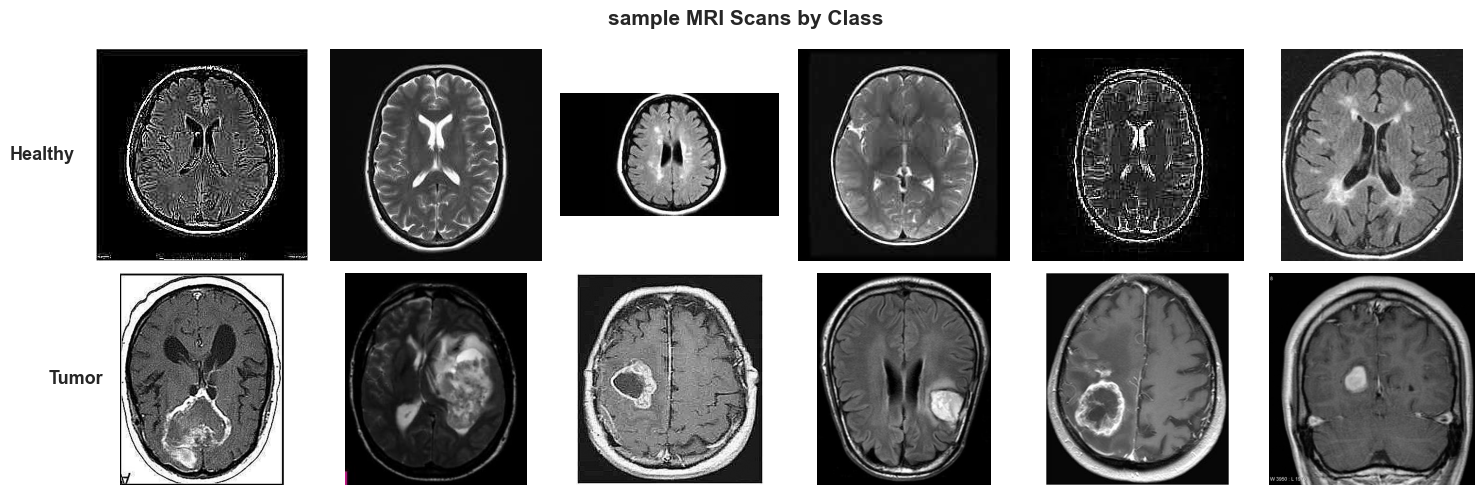

In [27]:
# sample Visualization
def display_sample_images(data_dir, samples_per_class=6):
    """display grid of sample images from each class"""
    
    classes = [cls for cls in os.listdir(data_dir) 
               if os.path.isdir(os.path.join(data_dir, cls))]
    
    # map to cleaner names
    class_names = {'tumor': 'Tumor', 'healthy': 'Healthy'}
    
    fig, axes = plt.subplots(len(classes), samples_per_class, 
                             figsize=(15, 5))
    
    for i, cls in enumerate(classes):
        class_path = os.path.join(data_dir, cls)
        images = [f for f in os.listdir(class_path) 
                 if f.endswith(('.jpg', '.png', '.jpeg'))]
        
        # random sample
        samples = random.sample(images, min(samples_per_class, len(images)))
        
        for j, img_name in enumerate(samples):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            
            ax = axes[i, j] if len(classes) > 1 else axes[j]
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            
            if j == 0:
                display_name = class_names.get(cls, cls)
                ax.text(-0.1, 0.5, display_name, 
                       transform=ax.transAxes,
                       fontsize=13, fontweight='bold',
                       verticalalignment='center',
                       horizontalalignment='right')
    
    plt.suptitle('sample MRI Scans by Class', fontsize=15, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig("../graphics/sample_images.png", bbox_inches="tight", dpi=150)
    plt.show()

display_sample_images(data_dir, samples_per_class=6)

## Visual Sample Analysis

The figure above displays representative MRI scans from both classes. A few observations stand out:

**Healthy scans** - show clear, symmetrical brain structures with well-defined boundaries between gray and white matter. The ventricles appear normal in size and shape, and there are no obvious irregular bright or dark regions that would suggest abnormalities.

**Tumor scans** - exhibit noticeable irregularities—bright hyperintense regions that disrupt the normal brain architecture, asymmetrical features, and in some cases, visible mass effects where tissue appears compressed or displaced. The variability within the tumor class is apparent, with tumors appearing in different locations and presenting varying sizes and intensities.

Both classes show consistent image quality and similar contrast characteristics, which is good for model training. The visual differences between classes are clear enough that a well-trained model should be able to learn discriminative features, but subtle enough that careful preprocessing and architecture selection will matter.

### Model Plan

**Architecture**  
- EfficientNetV2-S with ImageNet pretrained weights
- Replace final FC layer with custom head: dropout → linear → sigmoid
- Binary classification output (tumor vs healthy)

**Preprocessing**  
- Resize to 224×224, convert to RGB, normalize with ImageNet stats
- Training augmentation: horizontal flips, ±10° rotation, brightness/contrast adjustment
- No augmentation on validation/test sets

**Training Setup**  
- **Stage 1 (Head Training):** Freeze model backbone, train classifier head only for 10 epochs
- **Stage 2 (Fine-tuning):** Unfreeze all layers, train end-to-end for 15 epochs with lower learning rate
- Binary Cross-Entropy loss, ReduceLROnPlateau scheduler 
- Early stopping applied during stage 2
- 70/15/15 stratified split, batch size 32

**Regularization**  
- Dropout (p=0.5) in classifier head
- Weight decay in optimizer
- Data augmentation

**Evaluation**  
- Metrics: accuracy, precision, recall, F1, AUC-ROC
- Focus on recall for medical context 
- Confusion matrix for error analysis
- Training loss chart

**Interpretability**  
- Grad-CAM on final conv layer 
- Generate heatmaps showing regions influencing predictions
- Validate model focuses on anatomically relevant features
- Analyze both correct and incorrect predictions

**Expected Performance**  
- Target: 90%+ validation accuracy
- Challenge: generalization on limited dataset size